In [2]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as FF
import torch.optim as optim

from torchvision import transforms

In [3]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Generator

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1),
                nn.Tanh()
        )

    def forward(self, z):
        out = list()
        out.append(self.layer1(z))
        out.append(self.layer2(out[0]))

        out[1] = out[1].view(z.shape[0], 128, 7, 7)
        out.append(self.layer3(out[1]))
        out.append(self.last(out[2]))

        return out[3]

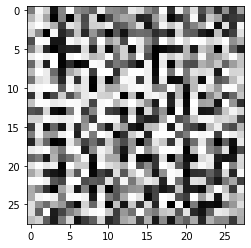

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

input_z = torch.randn(2, 20)

fake_images = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

# Discriminator

In [8]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4,
                    stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                    stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.z_layer1 = nn.Linear(z_dim, 512)

        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):

        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out
        feature = feature.view(feature.size()[0], -1)

        out = self.last2(out)

        return out, feature

In [13]:
D = Discriminator(z_dim=20)

input_z = torch.randn(2, 20)
fake_images = G(input_z)

d_out, _ = D(fake_images, input_z)

print(nn.Sigmoid()(d_out))

tensor([[0.5834],
        [0.5529]], grad_fn=<SigmoidBackward>)


# Encoder

In [14]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,
                      stride=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))

        # ここまでで画像のサイズは7×7になっている
        self.last = nn.Linear(128 * 7 * 7, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # FCに入れるためにテンソルの形を整形
        out = out.view(-1, 128 * 7 * 7)
        out = self.last(out)

        return out

In [17]:
E = Encoder(z_dim=20)

x = fake_images

z = E(x)

print(z.shape)
print(z)


torch.Size([2, 20])
tensor([[-0.2882,  0.4200,  0.3916, -0.1665, -0.0155,  0.0690,  0.6992, -0.2967,
         -0.0259, -0.0328,  0.3739, -0.4804, -0.2164,  0.1718, -0.0460,  0.2735,
          0.2188,  0.6101,  0.0205,  0.3543],
        [ 0.2812,  0.2442, -0.0709, -0.3129,  0.1180, -0.2674,  0.6027, -0.1845,
          0.4492,  0.1100, -0.0762, -0.3542,  0.9988,  0.4828, -0.1011,  0.3597,
         -0.1865,  0.1931, -0.3624,  0.0184]], grad_fn=<AddmmBackward>)


In [19]:
def make_datapath_list():

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [20]:
class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [21]:
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed

In [23]:
train_img_list=make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 28, 28])


# Train

In [28]:
def train_model(G, D, E, dataloader, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    E.to(device)
    D.to(device)

    G.train()
    E.train()
    D.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_e_loss = 0.0
        epoch_d_loss = 0.0

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        for imges in dataloader:

            if imges.size()[0] == 1:
                continue

            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            imges = imges.to(device)

            # --------------------
            # Discriminator
            # --------------------
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # Generator
            # --------------------
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            g_loss = criterion(d_out_fake.view(-1), label_real)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # Encoder
            # --------------------
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            e_loss = criterion(d_out_real.view(-1), label_fake)

            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("iteration:", iteration)

    return G, D, E

In [29]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)


# 初期化の実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (x_layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (x_layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (z_layer1): Linear(in_features=20, out_features=512, bias=True)
  (last1): Sequential(
    (0): Linear(in_features=3648, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last2): Linear(in_features=1024, out_features=1, bias=True)
)

In [30]:
num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス： cpu
-------------
Epoch 0/1500
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1513 ||Epoch_G_Loss:0.0754 ||Epoch_E_Loss:0.0770
timer:  3.7653 sec.
-------------
Epoch 1/1500
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.1475 ||Epoch_G_Loss:0.0774 ||Epoch_E_Loss:0.0787
timer:  2.7417 sec.
-------------
Epoch 2/1500
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.1434 ||Epoch_G_Loss:0.0797 ||Epoch_E_Loss:0.0812
timer:  2.7191 sec.
-------------
Epoch 3/1500
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.1394 ||Epoch_G_Loss:0.0816 ||Epoch_E_Loss:0.0841
timer:  2.6181 sec.
-------------
Epoch 4/1500
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.1361 ||Epoch_G_Loss:0.0834 ||Epoch_E_Loss:0.0865
timer:  2.7159 sec.
-------------
Epoch 5/1500
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.1325 ||Epoch_G_Loss:0.0850 ||Epoch_E_Loss:0.0894
timer:  2.7252 sec.
-------------
Epoch 6/1500
-------------

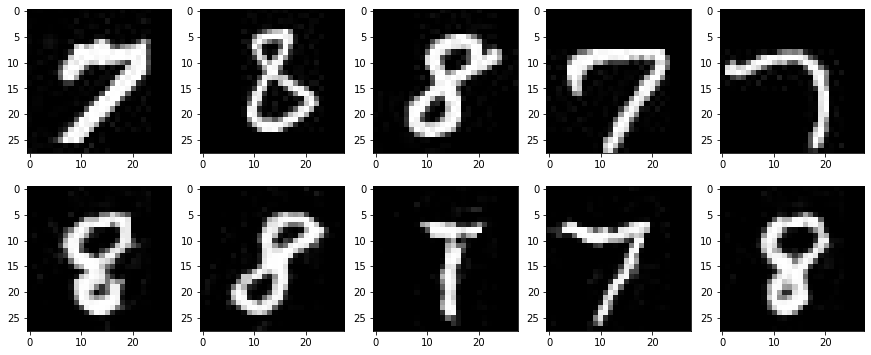

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
G_update.eval()
fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

In [32]:
def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()

    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


test_img_list = make_test_datapath_list()

mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

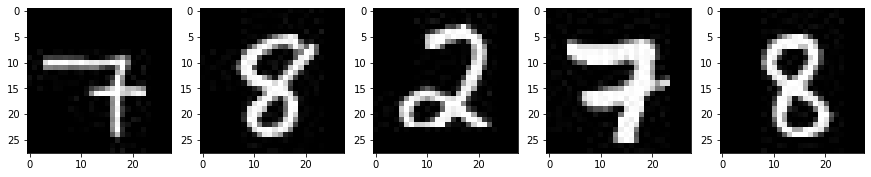

In [33]:
batch_iterator = iter(test_dataloader)
imges = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

In [34]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):

    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)


    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

total loss： [160. 236. 271. 280. 234.]


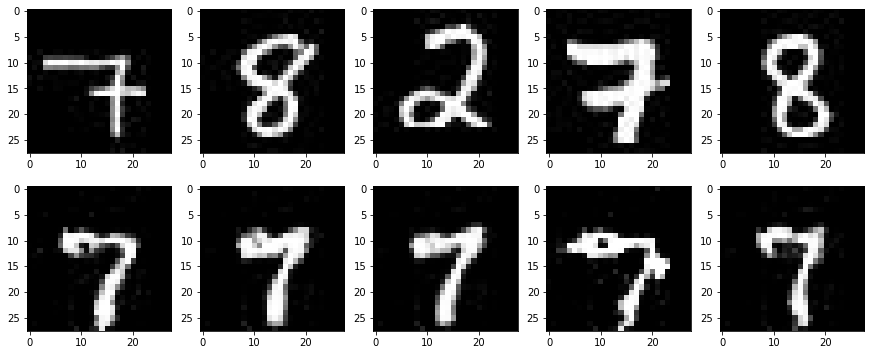

In [38]:
x = imges[0:5]
x = x.to(device)

E_update.eval()
G_update.eval()
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')